In [1]:
import os
import glob
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SIZE = 224
DATA_DIR = "D:/my progrAMS/#hackathon9/amazon/images/"


In [3]:
def load_images(path):
    images = []
    labels = []
    for directory_path in glob.glob(os.path.join(path, "*")):
        label = os.path.basename(directory_path)
        for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")) + glob.glob(os.path.join(directory_path, "*.jpg")):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    return np.array(images), np.array(labels)


In [4]:
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")


In [5]:
train_path = os.path.join(DATA_DIR, "train")
test_path = os.path.join(DATA_DIR, "test")


In [6]:
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Train or test directory not found")


In [ ]:

print("Loading training data...")
train_images, train_labels = load_images(train_path)
print("Loading test data...")
test_images, test_labels = load_images(test_path)

if len(train_images) == 0 or len(test_images) == 0:
    raise ValueError("No images found in train or test directories")

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images")


In [8]:
# Encode labels
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)


In [9]:
# Normalize pixel values
x_train, x_test = train_images.astype('float32') / 224.0, test_images.astype('float32') / 224.0
y_train, y_test = train_labels_encoded, test_labels_encoded


In [10]:
# One-hot encode labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
# Load VGG16 model
VGG_model = VGG16(weights='imagenet', include_top=True, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
    layer.trainable = False

In [12]:
model = Sequential([
    VGG_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(224, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(x_train, y_train_one_hot, epochs=60, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.3714 - loss: 1.0975 - val_accuracy: 0.0000e+00 - val_loss: 1.1017
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3429 - loss: 1.0973 - val_accuracy: 0.0000e+00 - val_loss: 1.1030
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3714 - loss: 1.0970 - val_accuracy: 0.0000e+00 - val_loss: 1.1043
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4571 - loss: 1.0976 - val_accuracy: 0.0000e+00 - val_loss: 1.1056
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4571 - loss: 1.0969 - val_accuracy: 0.0000e+00 - val_loss: 1.1069
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.4571 - loss: 1.0961 - val_accuracy: 0.0000e+00 - val_loss: 1.1082
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5429 - loss: 1.0949 - val_accuracy: 0.0000e+00 - val_loss: 1.1095
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5429 - loss: 1.0936 - val_accuracy: 0.

In [15]:
# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [16]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.29


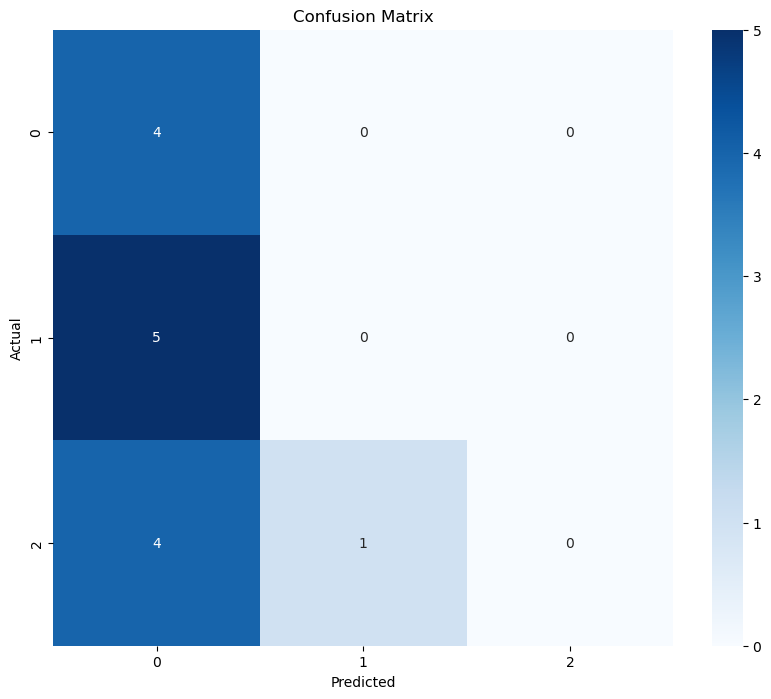

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


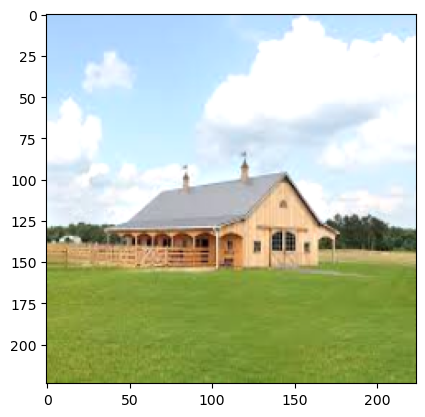

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
The prediction for this image is: barn
The actual label for this image is: barn


In [40]:

# Test on a random image
if len(x_test) > 0:
    n = np.random.randint(0, x_test.shape[0])
    img = x_test[n]
    plt.imshow(img)
    plt.show()

    input_img = np.expand_dims(img, axis=0)
    prediction = model.predict(input_img)
    predicted_class = le.inverse_transform([np.argmax(prediction)])[0]
    actual_class = le.inverse_transform([y_test[n]])[0]

    print(f"The prediction for this image is: {predicted_class}")
    print(f"The actual label for this image is: {actual_class}")
else:
    print("No test images available for individual prediction")